In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'H:\Tesseract-ocr\tesseract.exe'

%matplotlib inline
import os
from PIL import Image
from imutils.object_detection import non_max_suppression

Read Image File

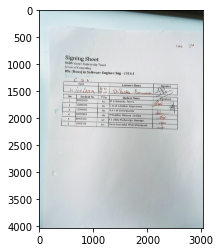

In [2]:
img = cv2.imread('1.jpeg')
plt.imshow(img)

Crop Image (Warning: Do not run twice or change file output name)

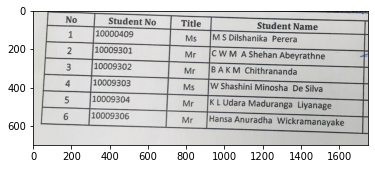

In [83]:
im = Image.open('1.jpeg')
im = im.crop((370,1550,2120,2250))
plt.imshow(im)

In [65]:
im.save('11.jpeg')

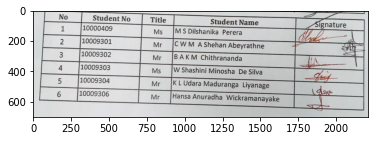

In [84]:
img = cv2.imread('11.jpeg')
plt.imshow(img)

Resize the Image

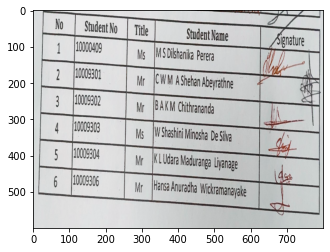

In [88]:
#scaled to 600 x 600 pixels 
scaled = cv2.resize(img, (800,600), fx = 0.1, fy = 0.1
                 ,interpolation = cv2.INTER_CUBIC)
plt.imshow(scaled)

Straightening image

(<AxesSubplot:title={'center':'Self implement warpPerspective'}>,
 Text(0.5, 1.0, 'Self implement warpPerspective'))

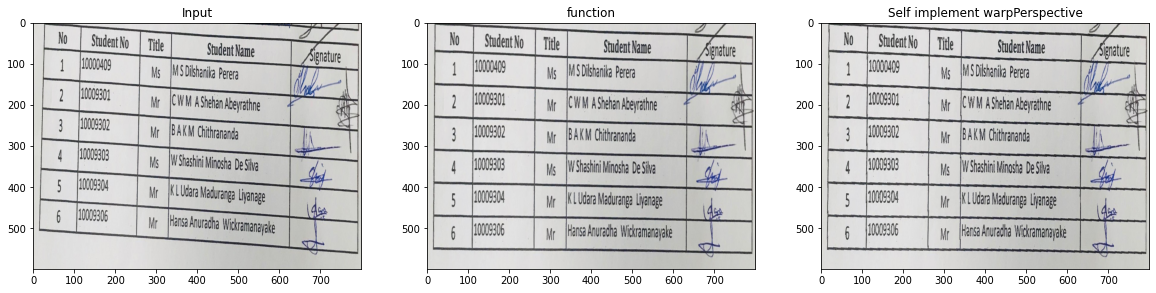

In [89]:
# Geomatric transform
# Projective
def getPerspective(src, res):
    src_x1, src_x2, src_x3, src_x4 = src[:, 0]
    src_y1, src_y2, src_y3, src_y4 = src[:, 1]
    dst_x1, dst_x2, dst_x3, dst_x4 = res[:, 0]
    dst_y1, dst_y2, dst_y3, dst_y4 = res[:, 1]
    
    A = np.float32([[src_x1, src_y1, 1, 0, 0, 0, -(src_x1 * dst_x1), -(dst_x1 * src_y1)],
                  [0, 0, 0, src_x1, src_y1, 1, -(src_x1 * dst_y1), -(dst_y1 * src_y1)],
                  [src_x2, src_y2, 1, 0, 0, 0, -(src_x2 * dst_x2), -(dst_x2 * src_y2)],
                  [0, 0, 0, src_x2, src_y2, 1, -(src_x2 * dst_y2), -(dst_y2 * src_y2)],
                  [src_x3, src_y3, 1, 0, 0, 0, -(src_x3 * dst_x3), -(dst_x3 * src_y3)],
                  [0, 0, 0, src_x3, src_y3, 1, -(src_x3 * dst_y3), -(dst_y3 * src_y3)],
                  [src_x4, src_y4, 1, 0, 0, 0, -(src_x4 * dst_x4), -(dst_x4 * src_y4)],
                  [0, 0, 0, src_x4, src_y4, 1, -(src_x4 * dst_y4), -(dst_y4 * src_y4)]])
    
    b = np.float32([dst_x1, dst_y1,
                  dst_x2, dst_y2,
                  dst_x3, dst_y3,
                  dst_x4, dst_y4])
  
    inverseA = np.linalg.inv(A)
    h = np.matmul(inverseA, b)
    M = np.float32([
        [h[0], h[1], h[2]],
        [h[3], h[4], h[5]],
        [h[6], h[7], 1]])
    
    return M

def warpPerspective(scaled, size, M):
    rows, cols = size
    for y in range(0, rows):
        for x in range(0, cols):
            P_prime = [x, y, 1]
            src_x = int(round(np.dot(M[0], P_prime) / np.dot(M[2], P_prime)))
            src_y = int(round(np.dot(M[1], P_prime) / np.dot(M[2], P_prime)))
            dst[y][x] = shapes_rgb[src_y][src_x]
    return dst

shapes_rgb = cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB)
rows, cols, ch = shapes_rgb.shape

A = np.float32([[10, 0], [0, 550], [800, 600], [800, 20]])

B = np.float32([[0, 0], [0, rows], [cols, rows], [cols, 0]])


dst = np.ones((rows, cols, ch), dtype=np.int32)

M = getPerspective(A, B)
inverseM = np.linalg.inv(M)
dst = warpPerspective(shapes_rgb, (rows, cols), inverseM)

M_func = cv2.getPerspectiveTransform(A, B)
shapes = cv2.warpPerspective(shapes_rgb, M_func, (cols, rows))

plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(shapes_rgb), plt.title('Input')
plt.subplot(132), plt.imshow(shapes), plt.title('function')
plt.subplot(133), plt.imshow(dst), plt.title('Self implement warpPerspective')

Binarization

In [90]:
gray = cv2.cvtColor(shapes,cv2.COLOR_BGR2GRAY)

In [91]:
canny_edges = cv2.Canny(gray, 100, 200)

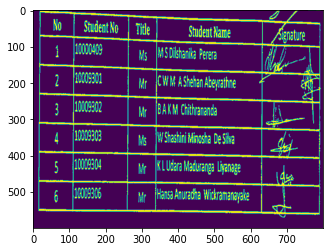

In [92]:
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(thresh)

vertical and horizontal kernals

In [93]:
kernel_len = np.array(gray).shape[1] // 100
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))


In [94]:
image_1 = cv2.erode(thresh, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
    #cv2.imwrite(path + 'vl.jpeg', vertical_lines)

In [95]:
image_2 = cv2.erode(thresh, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)

In [96]:
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)

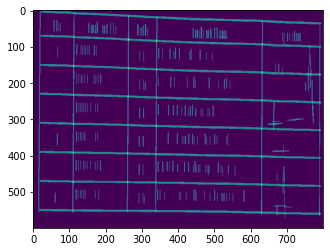

In [97]:
plt.imshow(img_vh)

detect lines

In [98]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return cnts, boundingBoxes

In [99]:
 # Find all contours in the image
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')


In [100]:
 # Set mean height (Approximated manually) - Approximated Number
meanHeight = 60

# Array of boxes to store extracted rectangles
box = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if 1500 > w > 100 and h > 50:
        box.append([x, y, w, h])
        cv2.rectangle(shapes, (x, y), (x + w, y + h), (0, 0, 255), 2)
        


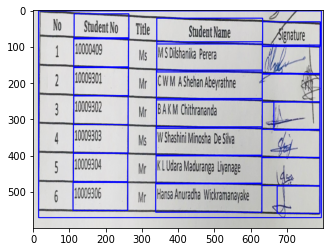

In [101]:
plt.imshow(shapes)

output as text

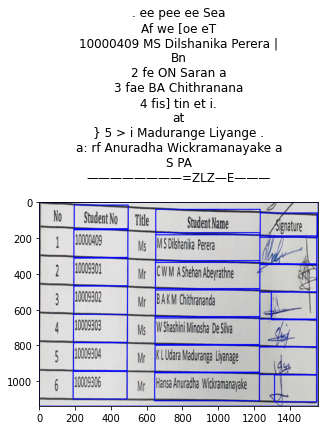

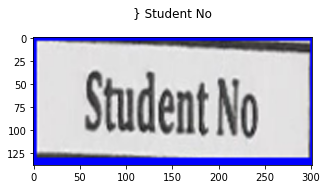

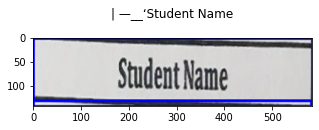

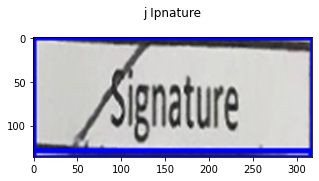

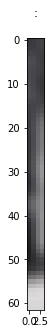

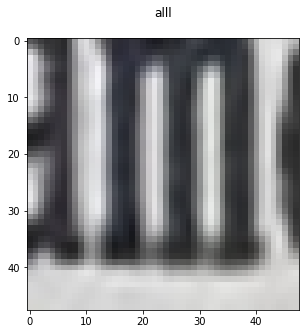

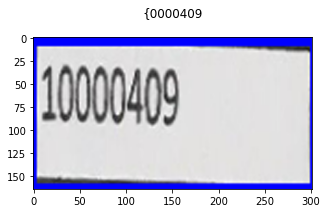

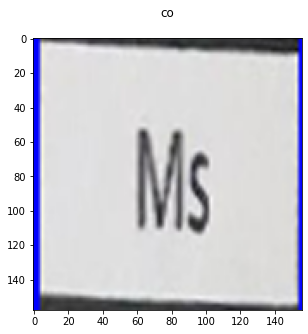

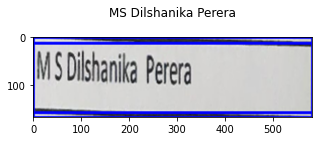

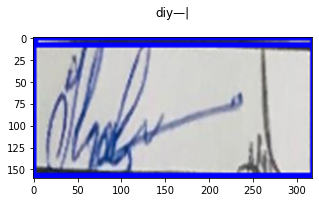

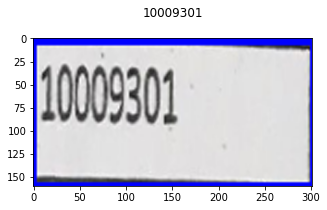

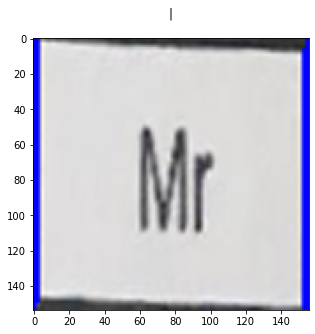

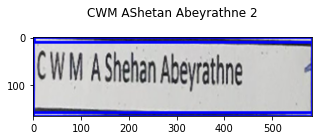

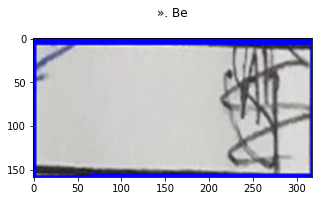

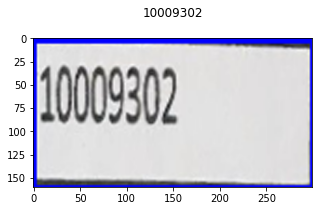

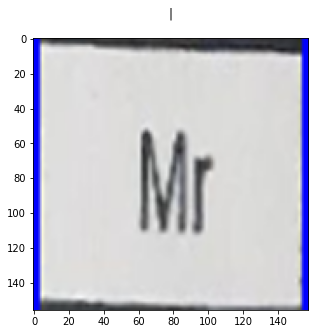

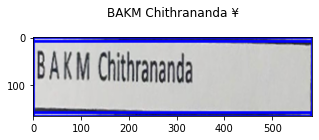

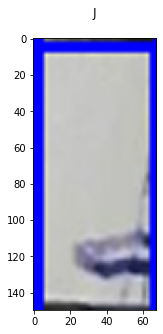

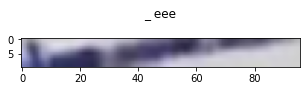

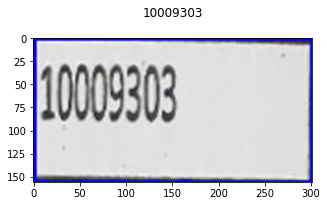

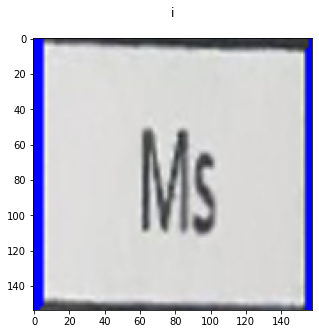

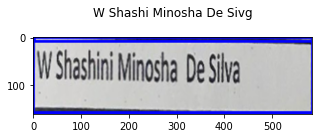

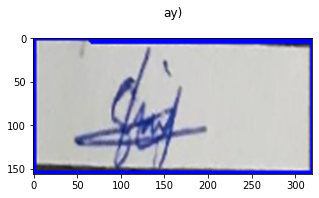

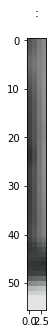

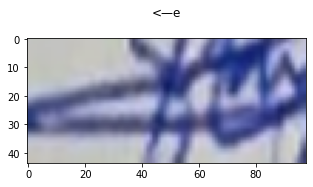

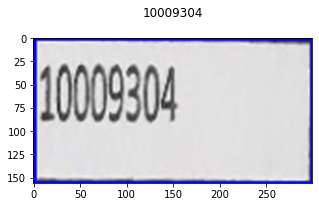

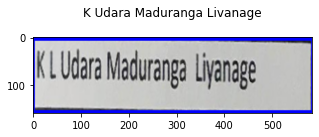

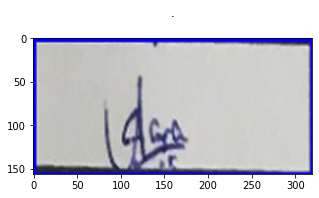

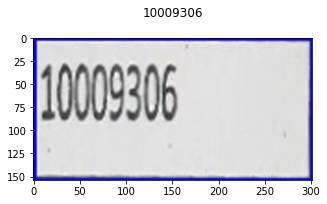

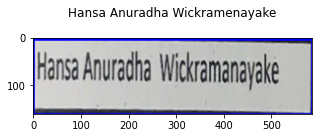

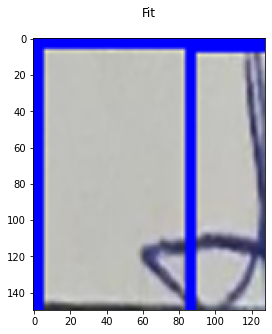

In [103]:
idx = 0
directory = 'outputs'
for c in contours:
    # Returns the location and width,height for every contour
    #print(f"C: {c}")
    #print(f"cv2.boundingRect: {cv2.boundingRect(c)}")
    x, y, w, h = cv2.boundingRect(c)
    idx += 1
    new_img = shapes[y:y+h, x:x+w]
    new_img = cv2.resize(new_img, (2 * new_img.shape[1], 2 * new_img.shape[0]), interpolation=cv2.INTER_CUBIC)
    #cv2.imwrite(os.path.join(directory , str(idx) + '.png'), new_img)
    
#     gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
#     blur = cv2.GaussianBlur(gray, (5, 5), 0)
#     _, thresh = cv2.threshold(blur, 70, 255, cv2.THRESH_BINARY_INV)

#     cv2.imwrite(str(idx)+"_1.png", thresh)
    #pytesseract.pytesseract.tesseract_cmd = r'/Users/nguyen/anaconda3/bin/tesseract'
    result = pytesseract.image_to_string(new_img, lang='eng',config='--psm 6')
    if (len(result) != 0):  
        #os.remove(str(idx)+"_1.png")
        #plt.rcParams.update({'figure.max_open_warning': 0})
        plt.figure(figsize=(5, 5))
        plt.imshow(new_img), plt.title(result, fontsize = '12')
        #print(result)
